Now we will build a wavelet transform in order to perform our diffusion on the market data, both macro and micro.

After conditioning: T = 7276, N_assets = 349
Building CWT Cube: Time=7276, Assets=349, Scales=32...


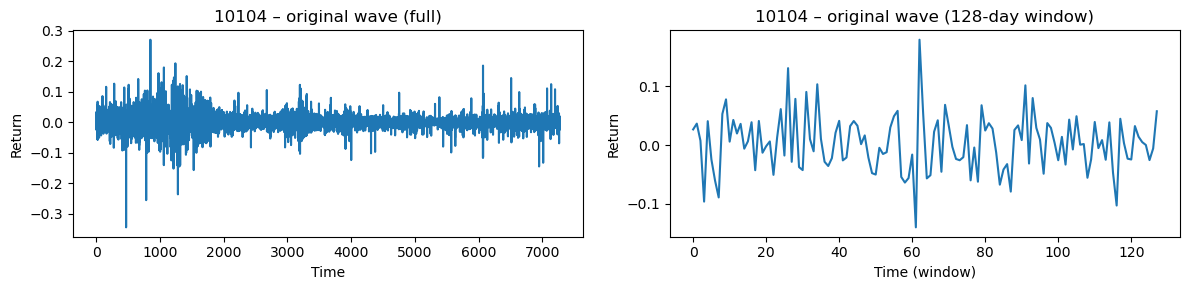

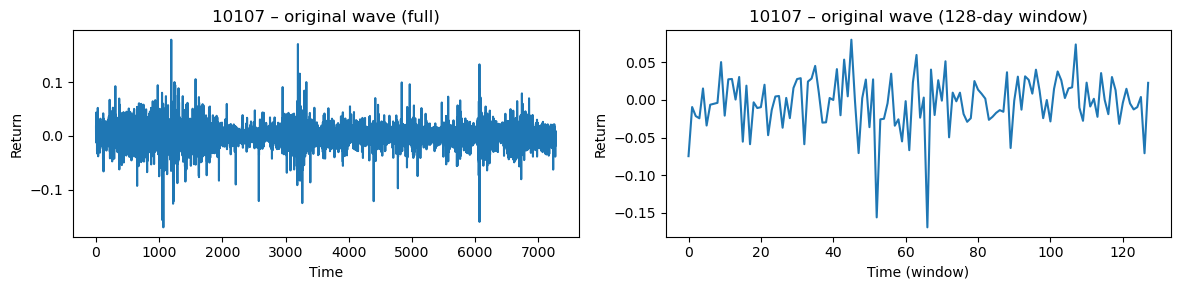

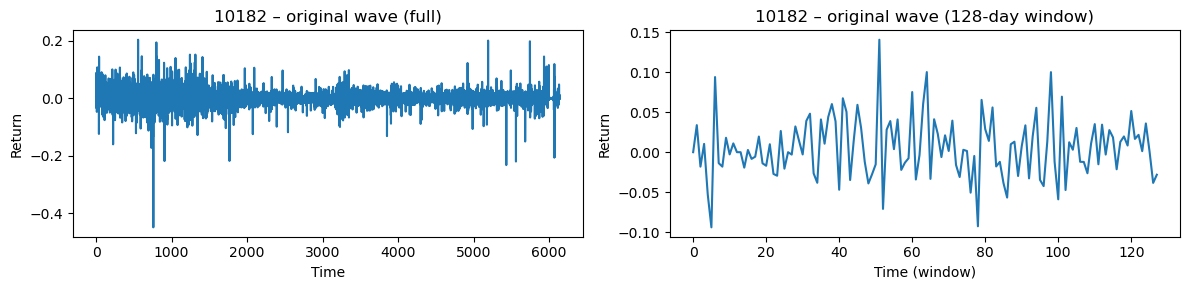

wavelet_cube shape = (7276, 349, 32)
Conditioning matrix shape = (7276, 1514)

🎉 DONE — All artifacts exported to /Users/dominicranelli/Desktop/BigProject/artifacts_all
Saved files:
 - X_all.npy (Shape: (7276, 349, 32))
 - C_all.npy (Shape: (7276, 1514))
 - date_index.npy
 - basket_assets.json


In [9]:
import os
import json
import numpy as np
import pandas as pd
import pywt

"""
Wavelet Feature Cube Builder (CWT Scalograms) for Financial Time Series

Loads a multi-asset panel (returns, prices, volume, fundamentals, macro, regime),
builds a Continuous Wavelet Transform (CWT) representation of each asset's return series,
and exports NumPy artifacts.

Output artifacts:
- X_all.npy: wavelet cube shaped (T, N_assets, N_scales)
- C_all.npy: conditioning matrix shaped (T, N_condition_features)
- date_index.npy: aligned time index
- basket_assets.json: asset universe (column names)

Author: Dominic Ranelli
"""

# Setting our import and export directories

INPUT_DIR  = "/Users/dominicranelli/Desktop/BigProject/artifacts"
OUTPUT_DIR = "/Users/dominicranelli/Desktop/BigProject/artifacts_all"

# We use a Morlet wavelet, as it is standard for financial and non-stationary signals.
CWT_WAVELET   = "morl"

# Using 32 scales to not explode memory 
CWT_SCALES    = np.arange(1, 33) 
N_SCALES      = len(CWT_SCALES)


# Time dependent and CWT hyperparameters
def condition_time_like(obj):
    """
    First we normalize dimension to single expected length

    We want to enforce a similar lengths of time (days)
    If T == 7300 (consistent for non-regime days, we drop the first 22 rows and last 2 which yields 7276
    If T == 7276, we keep
    This allows all days to have regime information involved
    """
    if isinstance(obj, (pd.Series, pd.DataFrame)):
        T = len(obj)
        if T == 7300:
            return obj.iloc[22:-2]
        elif T == 7276:
            return obj
        else:
            raise ValueError(f"Unexpected time length {T} for pandas object.")
    else:
        arr = np.asarray(obj)
        T = arr.shape[0]
        if T == 7300:
            return arr[22:-2, ...]
        elif T == 7276:
            return arr
        else:
            raise ValueError(f"Unexpected time length {T} for ndarray.")


def cwt_features_1d(x_1d: np.ndarray, wavelet_name: str, scales: np.ndarray) -> np.ndarray:
    """
    We compute the continuous wavelet transform for a 1-dimensional return series

    Parameters:
    x_1d: 1D array of shape (T,). Which holds daily log returns as well as simple returns
    wavelet_name: PyWavelets wavelet identifier
    scales: Array of scales where higher scales means longer horizon

    Returns:
    coeffs: Wavelet coefficient matrix of shape (N_scales, T = timesteps) as a float
    """
    x_1d = np.asarray(x_1d)

    # We get coefficients here
    coeffs, _ = pywt.cwt(x_1d, scales, wavelet_name)
    
    # Sanity check to ensure that the first dimension is the number of scales
    assert coeffs.shape[0] == len(scales)
    return coeffs.astype(np.float32)


# Building wavelet cube
def build_wavelet_cube(return_df: pd.DataFrame,
                       wavelet_name: str,
                       scales: np.ndarray) -> np.ndarray:
    """
    Build wavelet cube from return matrix DataFrame, using CWT.
    
    Input:
        return_df: DataFrame, index = dates, columns = assets (T x N)
        
    Output:
        wavelet_cube: ndarray of shape (T, N, N_scales).
        T: Time (e.g. 7276)
        N: Assets (e.g. 349)
        N_scales: Scales (e.g. 32)
    """
    T, N = return_df.shape
    N_scales = len(scales)
    WINDOW = 128
    t0 = 1000          # fixed, reproducible window

    print(f"Building CWT Cube: Time={T}, Assets={N}, Scales={N_scales}...")

    # Visual checks to ensure we are applying function correctly 
    cube = np.empty((T, N, N_scales), dtype=np.float32)
    plotted = 0
    
    for j, col in enumerate(return_df.columns):
        x = return_df[col].to_numpy(dtype=np.float32)

        # ---- ORIGINAL WAVES (BEFORE WAVELET) ----
        if plotted < 3:
            fig, ax = plt.subplots(1, 2, figsize=(12, 3))

            ax[0].plot(x)
            ax[0].set_title(f"{col} – original wave (full)")
            ax[0].set_xlabel("Time")
            ax[0].set_ylabel("Return")

            ax[1].plot(x[t0:t0+WINDOW])
            ax[1].set_title(f"{col} – original wave (128-day window)")
            ax[1].set_xlabel("Time (window)")
            ax[1].set_ylabel("Return")

            plt.tight_layout()
            plt.show()        # ← PUT IT HERE
            plotted += 1

    return cube


def main():
    """
    Full pipeline:
        1. Load parquet inputs
        2. Enforce time length and alignment
        3. Build wavelet cub X_all
        4. Build conditioning matrix C_all
        5. Exports
    """

    
    os.makedirs(OUTPUT_DIR, exist_ok=True)



    # Asset-level time series
    return_df = pd.read_parquet(os.path.join(INPUT_DIR, "return_matrix.parquet"))
    price_df  = pd.read_parquet(os.path.join(INPUT_DIR, "price_matrix.parquet"))
    volume_df = pd.read_parquet(os.path.join(INPUT_DIR, "volume_matrix.parquet"))

    # Fundamentals
    fund_df = pd.read_parquet(os.path.join(INPUT_DIR, "fundamentals_daily.parquet"))

    # Macro blocks
    fred_df = pd.read_parquet(os.path.join(INPUT_DIR, "macro_fred.parquet"))
    duka_df = pd.read_parquet(os.path.join(INPUT_DIR, "macro_duka_returns.parquet"))

    # Regime information
    regime_df = pd.read_parquet(os.path.join(INPUT_DIR, "regime_series.parquet"))
    if regime_df.shape[1] == 1:
        regime_sr = regime_df.iloc[:, 0]
    else:
        regime_sr = regime_df["regime"]

    # Ensure index sorted
    for df in [return_df, price_df, volume_df, fund_df, fred_df, duka_df, regime_sr.to_frame("regime")]:
        df.sort_index(inplace=True)



# Avoiding misalignment
    return_df = condition_time_like(return_df)
    price_df  = condition_time_like(price_df)
    volume_df = condition_time_like(volume_df)
    fund_df = condition_time_like(fund_df)
    fred_df = condition_time_like(fred_df)
    duka_df = condition_time_like(duka_df)
    regime_sr = condition_time_like(regime_sr)

    T = len(return_df)
    N = return_df.shape[1]
    print(f"After conditioning: T = {T}, N_assets = {N}")  # expect T ~7276

    # Alignment checks
    idx = return_df.index
    for name, df_like in [
        ("price_df", price_df),
        ("volume_df", volume_df),
        ("fund_df", fund_df),
        ("fred_df", fred_df),
        ("duka_df", duka_df),
    ]:
        if not df_like.index.equals(idx):
            raise ValueError(f"Index mismatch after conditioning for {name}")

    if not pd.Index(regime_sr.index).equals(idx):
        raise ValueError("Index mismatch for regime_sr")


    # Building wavelet cube
    wavelet_cube = build_wavelet_cube(
        return_df=return_df,
        wavelet_name=CWT_WAVELET,
        scales=CWT_SCALES,
    )
    print("wavelet_cube shape =", wavelet_cube.shape)
    # Expected shape: (T, N, 32)

    # -------------------------------------------------------------------------
    # 2.4 Build conditioning matrix: C_all
    # -------------------------------------------------------------------------

    C_all = np.hstack([
        fred_df.to_numpy(),                    # macro_FRED block
        duka_df.to_numpy(),                    # macro_duka block
        fund_df.to_numpy(),                    # fundamentals (wide)
        regime_sr.to_numpy().reshape(-1, 1),   # regime scalar
    ]).astype(np.float32)

    print("Conditioning matrix shape =", C_all.shape)

    # -------------------------------------------------------------------------
    # 2.5 Date index + basket assets
    # -------------------------------------------------------------------------

    # Date index = time index from the asset panel
    date_index = idx.to_numpy()

    # Basket assets = asset universe from return_df columns
    basket_assets = list(return_df.columns.astype(str))

    # -------------------------------------------------------------------------
    # 2.6 Save final artifacts
    # -------------------------------------------------------------------------

    np.save(os.path.join(OUTPUT_DIR, "X_all.npy"), wavelet_cube)
    np.save(os.path.join(OUTPUT_DIR, "C_all.npy"), C_all)
    np.save(os.path.join(OUTPUT_DIR, "date_index.npy"), date_index)

    with open(os.path.join(OUTPUT_DIR, "basket_assets.json"), "w") as f:
        json.dump(basket_assets, f)

    print("\n🎉 DONE — All artifacts exported to", OUTPUT_DIR)
    print("Saved files:")
    print(f" - X_all.npy (Shape: {wavelet_cube.shape})")
    print(f" - C_all.npy (Shape: {C_all.shape})")
    print(" - date_index.npy")
    print(" - basket_assets.json")


if __name__ == "__main__":
    main()